# Lab2 - AI - Convolutional Neural networks for image recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

In this lab, we will first build and train a convolutional neural network (CNN) for digit recognition from the MNIST dataset. Results will be compared with those obtained by neural networks in Lab1.

In the second part, we build and train CNNs for color object detection from the CIFAR10 dataset.

This lab was prepared based on the tutorials: (https://datahacker.rs/005-pytorch-convolutional-neural-network-on-mnist-in-pytorch/) and (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

Please note that the implementations from these tutorials need to be adapted and corrected. A simple copy/paste will not work.


**Setting up the environment**


In [ ]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# what is your GPU ?
!nvidia-smi

Mon Dec  4 11:13:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PART 1: CNNs for digit recognition from MNIST dataset

### **1. Loading MNIST dataset from torchvision**

In [ ]:
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data and the validation (test) data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 162927636.07it/s]

Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 133409354.43it/s]


Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65111578.26it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21897159.50it/s]


Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  60000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


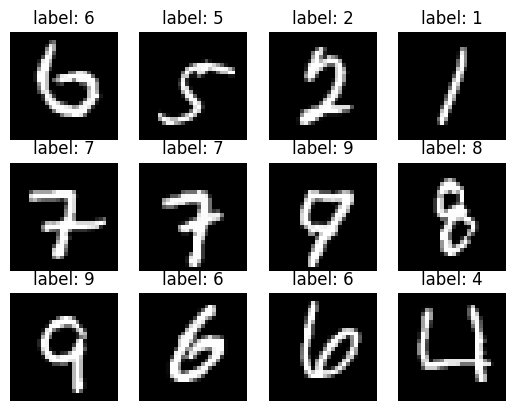

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray'); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

### **2. Build a convolutional neural network**

Let's define a **convolutional neural network** with 2 conv layers and 1 fc layer
- first conv layer: 32 filters of size $5\times 5$, stride 1, padding 2
- maxpooling layer: size 2
- second conv layer: 64 filters of size $5\times 5$, stride 1, padding 2
- maxpooling layer: size 2
- fully-connected layer with 128 neurons
- activation ReLu (after each conv layer and the fc layer)
- do not use *dropout* layer (as proposed in the tutorial) for the moment

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch to have the size of (batch_size,32*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Let's now initialize the network

In [ ]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

**---------------Question 1---------------**

*   Cacluate the output size of feature maps after each layer of the network.
*   Calculate also the total number of parameters of the network
*   Print the total number of trainable parameters in Pytorch ?

In [ ]:
# print number of total trainable parameters
# to complete
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

454922


### **3. Train the model**

Let's set up the optimizer and the loss function. You can use the Stochastic Gradient Descent optimizer (SGD) and the Cross-entropy loss as proposed by the tutorial.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

Now train and evaluate/validate the model (during the training)

In [ ]:
import time
epochs = 10
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    model.train()
    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))


Epoch: 0/10   Training loss: 0.9156   Validation loss: 0.3123   Train accuracy: 0.7720   Validation accuracy: 0.9104  
Epoch: 1/10   Training loss: 0.2661   Validation loss: 0.2011   Train accuracy: 0.9223   Validation accuracy: 0.9425  
Epoch: 2/10   Training loss: 0.1896   Validation loss: 0.1564   Train accuracy: 0.9436   Validation accuracy: 0.9542  
Epoch: 3/10   Training loss: 0.1463   Validation loss: 0.1230   Train accuracy: 0.9573   Validation accuracy: 0.9609  
Epoch: 4/10   Training loss: 0.1193   Validation loss: 0.0982   Train accuracy: 0.9654   Validation accuracy: 0.9720  
Epoch: 5/10   Training loss: 0.1016   Validation loss: 0.0861   Train accuracy: 0.9706   Validation accuracy: 0.9756  
Epoch: 6/10   Training loss: 0.0886   Validation loss: 0.0872   Train accuracy: 0.9743   Validation accuracy: 0.9735  
Epoch: 7/10   Training loss: 0.0799   Validation loss: 0.0697   Train accuracy: 0.9761   Validation accuracy: 0.9799  
Epoch: 8/10   Training loss: 0.0727   Validation

Let’s plot our loss and accuracies and see if they are falling or growing.



Text(0.5, 1.0, 'Train and validation losses')

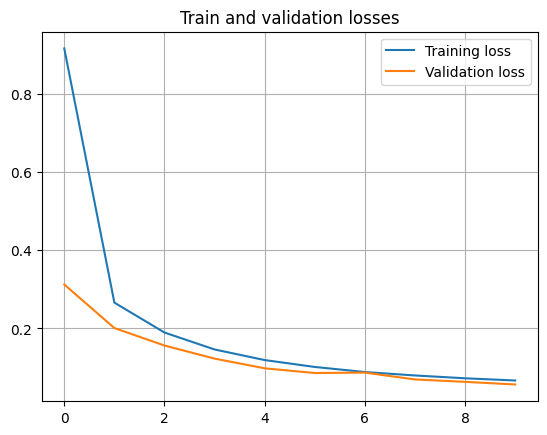

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses')

Text(0.5, 1.0, 'Train and validation accuracies')

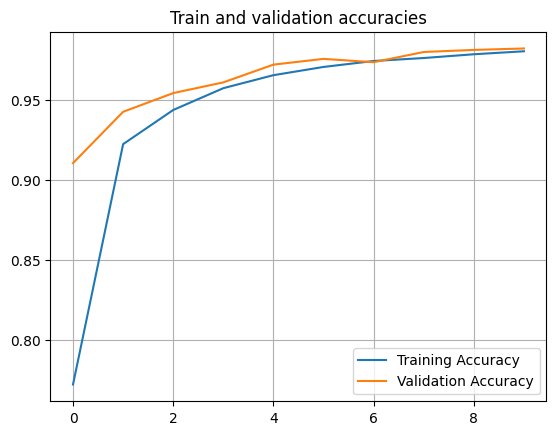

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies')

**---------------Question 2---------------**

*  Your remarks and comments about the training process compared to the neural networks in Lab1 ?
*  How could we improve the performance ?

### **4. Evaluation a trained network**

Once our model is trained, we can simply use the trained weights to make some new predictions by turning off the gradients.

Let's first predict label for a single image.

In [ ]:
test_id = 3
img = images[test_id].view(1,1,28, 28)
print(img.shape)
print(labels[test_id].numpy().squeeze())

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img.to(device))

print(logits)

torch.Size([1, 1, 28, 28])
1
tensor([[-2.1612,  7.7592,  0.9491, -1.9716,  1.2571, -2.4134, -0.3194,  1.8398,
          0.4334, -2.5242]], device='cuda:0')


[4.8847254e-05 9.9360210e-01 1.0955534e-03 5.9048278e-05 1.4906384e-03
 3.7958096e-05 3.0811501e-04 2.6696404e-03 6.5415207e-04 3.3978009e-05]


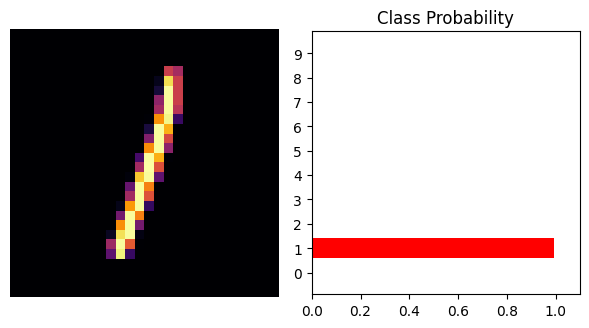

In [ ]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

Predict labels for a batch

In [ ]:
images, labels = next(iter(validationLoader))

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

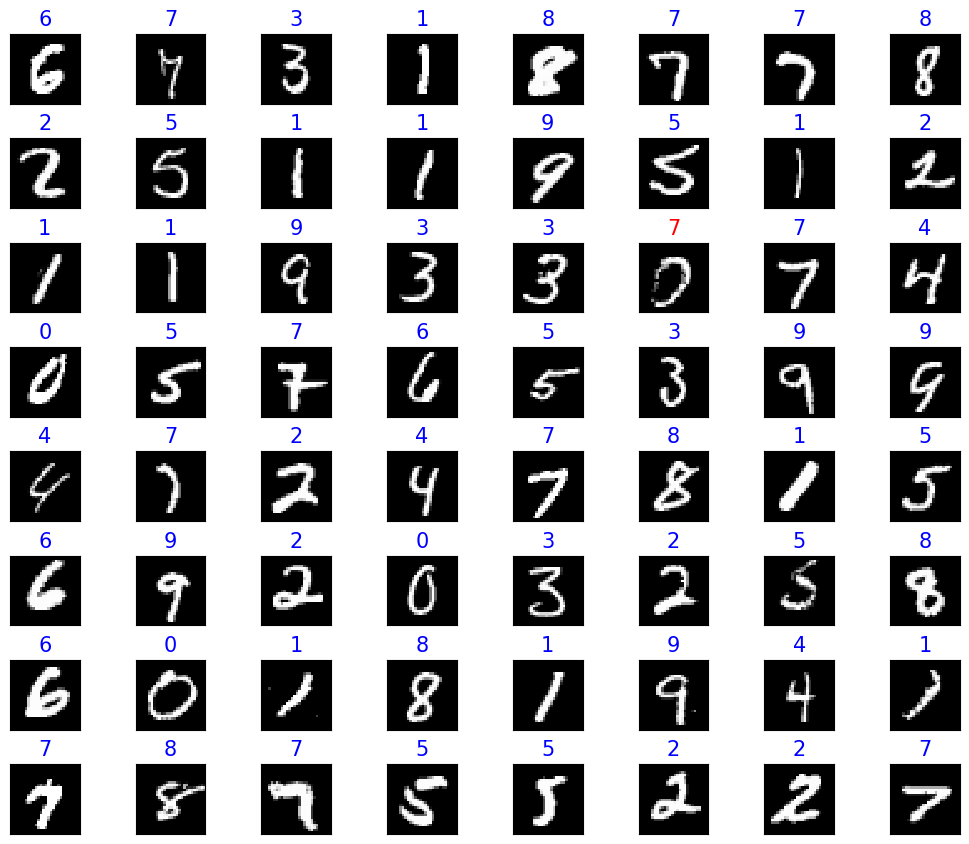

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)

Calculate the performance on the whole validation set

In [ ]:
# (similar to what has been done during the training process with validation)
model.eval()
total = 0
for idx, (image, label) in enumerate(validationLoader):
    image, label = image.cuda(), label.cuda()
    pred = model(image)
    loss = criterion(pred, label)
    total_val_loss += loss.item()

    pred = torch.nn.functional.softmax(pred, dim=1)
    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
accuracy_val = total / len(validation_set)

print('Accuracy on the validation set : ', accuracy_val )

Accuracy on the validation set :  0.9821


### **5. Building other CNNs**
You can also create and test other CNNs by changing the number of filters, adding more layers, etc.

Report the performance and comments on your work
  

In [ ]:
# your work


In [ ]:
# your work


In [ ]:
# your work

## PART 2: CNNs for color object recognition from CIFAR10 dataset

Now let's build CNN models to work on the CIFAR10 dataset.

Try to reach the best performance on validation by designing other CNNs.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [01:18<00:00, 2184683.02it/s]


Extracting DATA_CIFAR/cifar-10-python.tar.gz to DATA_CIFAR/
Files already downloaded and verified


In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 3, 32, 32])
torch.Size([64])


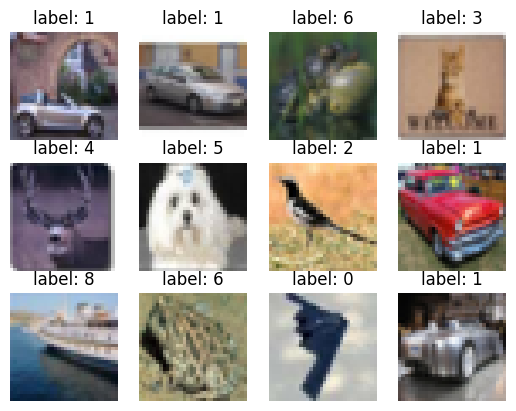

In [ ]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [ ]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # different from Mnist
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

579402


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/20   Training loss: 2.2221   Validation loss: 2.0692   Train accuracy: 0.1950   Validation accuracy: 0.2835  
Epoch: 1/20   Training loss: 1.9416   Validation loss: 1.8349   Train accuracy: 0.3153   Validation accuracy: 0.3494  
Epoch: 2/20   Training loss: 1.7715   Validation loss: 1.7198   Train accuracy: 0.3730   Validation accuracy: 0.3983  
Epoch: 3/20   Training loss: 1.6520   Validation loss: 1.5975   Train accuracy: 0.4112   Validation accuracy: 0.4252  
Epoch: 4/20   Training loss: 1.5635   Validation loss: 1.5677   Train accuracy: 0.4406   Validation accuracy: 0.4344  
Epoch: 5/20   Training loss: 1.4950   Validation loss: 1.4767   Train accuracy: 0.4657   Validation accuracy: 0.4662  
Epoch: 6/20   Training loss: 1.4388   Validation loss: 1.4293   Train accuracy: 0.4868   Validation accuracy: 0.4918  
Epoch: 7/20   Training loss: 1.3945   Validation loss: 1.4463   Train accuracy: 0.5022   Validation accuracy: 0.4705  
Epoch: 8/20   Training loss: 1.3593   Validation

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

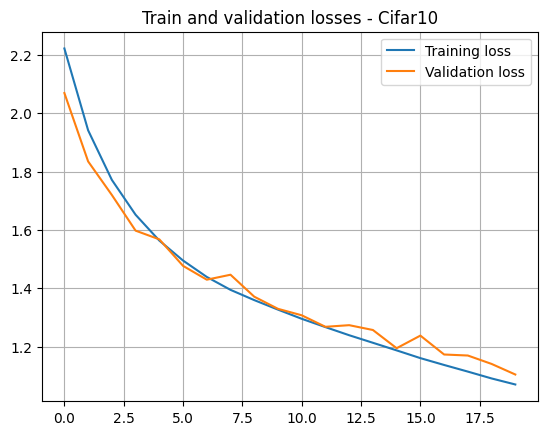

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

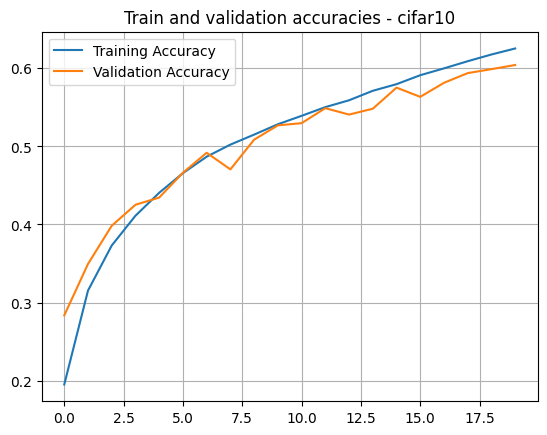

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

**---------------Question 3---------------**

*  Your remarks and comments about the training process and the performance of CNN on Cifar10 ?
*  How could we improve the performance ?